### Connect to cluster

In [1]:
import os
import dask
import time
import joblib
import fsspec
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML
from dask_ml.xgboost import XGBRegressor

from azureml.core import Run, Model

%matplotlib inline

In [2]:
run = Run.get_context()
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-dask-demo,dask-dask-demo_1580592415_63cfafe7,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [3]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.3.0.7:8786 Dashboard: http://10.3.0.7:8787/status,Cluster Workers: 25 Cores: 400 Memory: 2.96 TB


In [4]:
STORAGE_OPTIONS = {
    'account_name': run.experiment.workspace.datastores['gen2'].account_name,
    'account_key' : run.experiment.workspace.datastores['gen2'].account_key
}

protocol  = 'abfs'
container = 'datasets'

In [5]:
fs = fsspec.filesystem(protocol, **STORAGE_OPTIONS, container_name=container)

In [6]:
files = fs.glob('out/dask/noaa-isd/*')
files = [f'{protocol}://{container}/{file}' for file in files]
files[-5:]

['abfs://datasets/out/dask/noaa-isd/part127-data.csv',
 'abfs://datasets/out/dask/noaa-isd/part128-data.csv',
 'abfs://datasets/out/dask/noaa-isd/part129-data.csv',
 'abfs://datasets/out/dask/noaa-isd/part130-data.csv',
 'abfs://datasets/out/dask/noaa-isd/part131-data.csv']

In [7]:
df = dd.read_csv(files, storage_options=STORAGE_OPTIONS, dtype={'usaf': 'object'}, blocksize='5GB').persist()
%time df.head()

CPU times: user 530 ms, sys: 30.9 ms, total: 561 ms
Wall time: 2min 5s


,Unnamed: 0,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,2008-01-01,724755,93129,2008-01-01 00:53:00,37.702,-113.097,1712.0,350.0,3.6,17.06,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
1,2008-01-01,434040,99999,2008-01-01 06:00:00,9.650,80.017,3.0,320.0,2.6,83.12,...,NaN,24.0,0.0,NaN,JAFFNA,CE,434040-99999,2008,1,1.0
2,2008-01-01,719090,99999,2008-01-01 00:00:00,63.750,-68.550,34.0,0.0,0.0,-29.74,...,NaN,NaN,NaN,NaN,IQALUIT,CA,719090-99999,2008,1,1.0
3,2008-01-01,719090,99999,2008-01-01 01:00:00,63.750,-68.550,34.0,350.0,2.1,-29.20,...,NaN,NaN,NaN,NaN,IQALUIT,CA,719090-99999,2008,1,1.0
4,2008-01-01,719090,99999,2008-01-01 02:00:00,63.750,-68.550,34.0,0.0,0.0,-31.00,...,NaN,NaN,NaN,NaN,IQALUIT,CA,719090-99999,2008,1,1.0


In [8]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist() 
%time len(df)

CPU times: user 124 ms, sys: 16 ms, total: 140 ms
Wall time: 13.4 s


1270243333

In [9]:
%time len(df)

CPU times: user 84.2 ms, sys: 7.71 ms, total: 91.9 ms
Wall time: 238 ms


1270243333

In [10]:
%time df.describe().compute()

CPU times: user 8.1 s, sys: 179 ms, total: 8.28 s
Wall time: 2min 2s


,wban,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.270243e+09,1.270243e+09,1.270243e+09,1.270243e+09,1.013709e+09,1.053004e+09,1.247780e+09,4.429675e+08,1.133391e+08,4.778603e+07,2.635686e+08,2.635686e+08,6.999535e+06,1.270243e+09,1.270243e+09,1.270243e+09
mean,6.987966e+04,3.757216e+01,-3.953360e+01,3.982165e+02,1.650804e+02,3.441704e+00,5.354870e+01,1.014653e+03,2.889832e+01,4.276644e+00,8.590938e+00,9.023999e+02,1.885553e+01,2.013246e+03,1.572223e+01,1.000000e+00
std,3.908999e+04,2.138076e+01,7.862546e+01,5.996861e+02,1.145702e+02,2.869097e+00,2.243441e+01,9.389093e+00,2.905005e+01,2.996370e+00,1.846843e+01,2.849152e+03,3.501295e+01,3.125733e+00,8.811851e+00,0.000000e+00
min,1.000000e+02,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-1.274800e+02,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,5.386700e+04,3.405000e+01,-9.532000e+01,5.000000e+01,8.000000e+01,2.000000e+00,4.730000e+01,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,9.999900e+04,4.161600e+01,-7.116000e+01,2.090000e+02,1.900000e+02,3.600000e+00,6.098000e+01,1.017200e+03,4.500000e+01,6.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,2.015000e+03,1.600000e+01,1.000000e+00
75%,9.999900e+04,4.920000e+01,1.769700e+01,5.490000e+02,2.800000e+02,5.700000e+00,8.204000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.018000e+03,2.400000e+01,1.000000e+00
max,9.999900e+04,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,1.430600e+02,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.018000e+03,3.100000e+01,1.000000e+00


In [11]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 464 ms, sys: 28 ms, total: 492 ms
Wall time: 6min 32s
Dataframe is: 745.37GB


In [12]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 214 ms, sys: 16.8 ms, total: 231 ms
Wall time: 26.8 s


,wban,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,72460.738757,37.851544,-41.404520,351.706004,176.364994,4.031225,33.424191,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,72872.565417,37.774122,-40.943714,352.504602,180.436673,4.306232,30.320744,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,73453.317961,37.781321,-40.130623,352.634351,156.904648,4.358461,30.441078,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,73655.388211,37.879647,-40.516726,353.027684,149.716467,4.318913,34.181907,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,73009.671893,37.956239,-41.565558,358.450412,161.096456,4.328847,39.053082,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


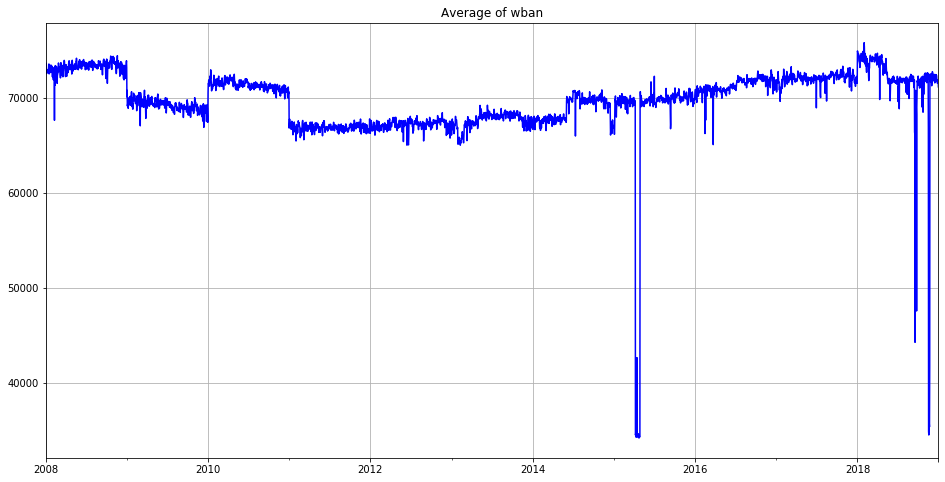

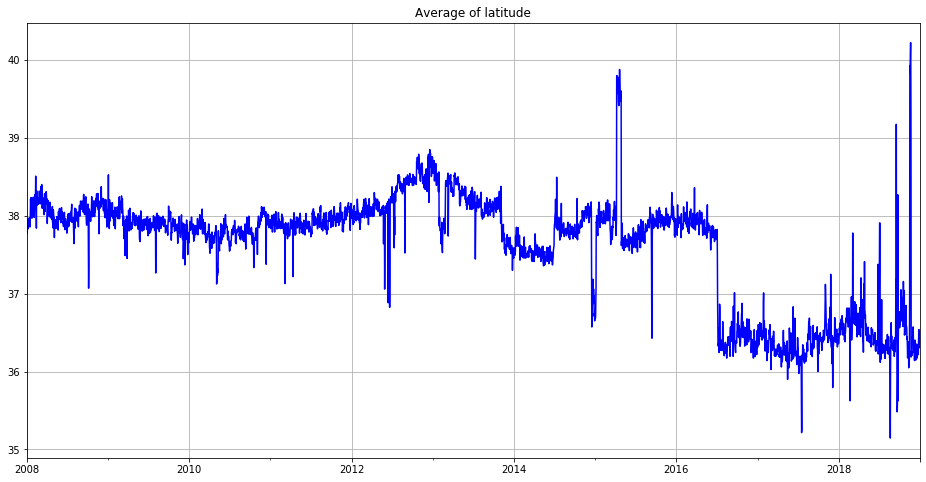

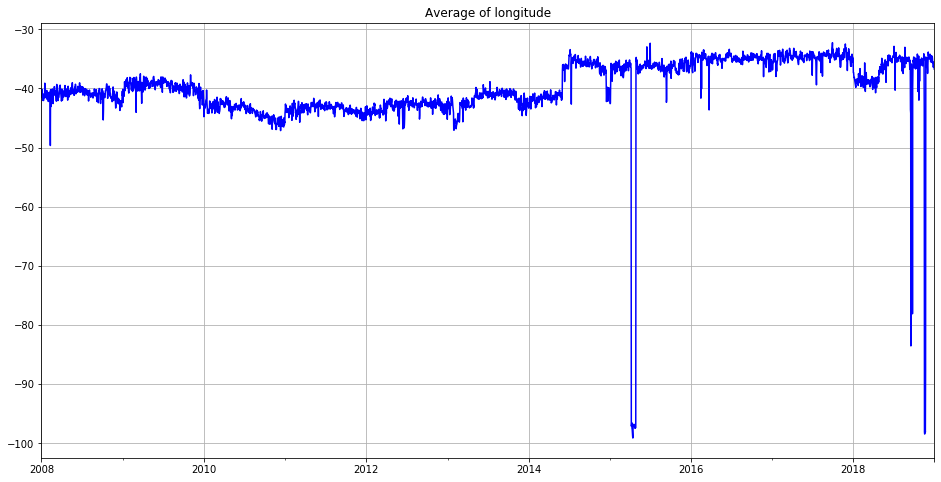

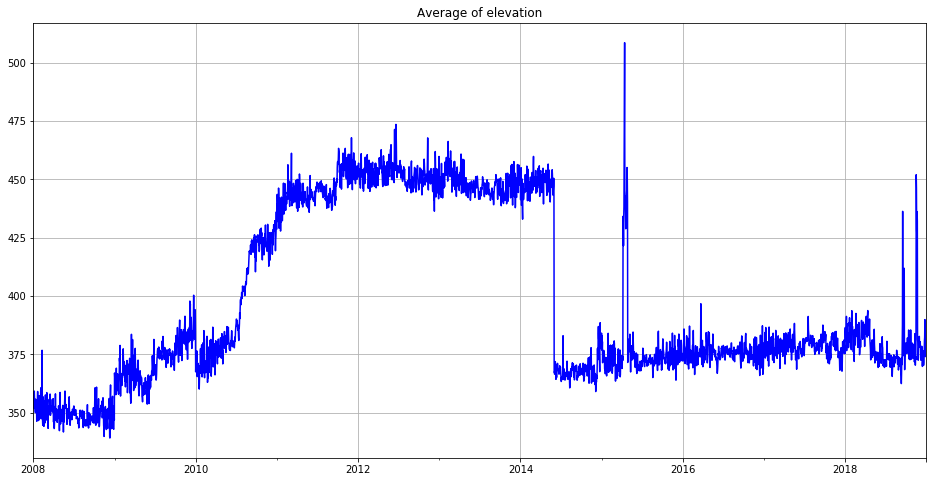

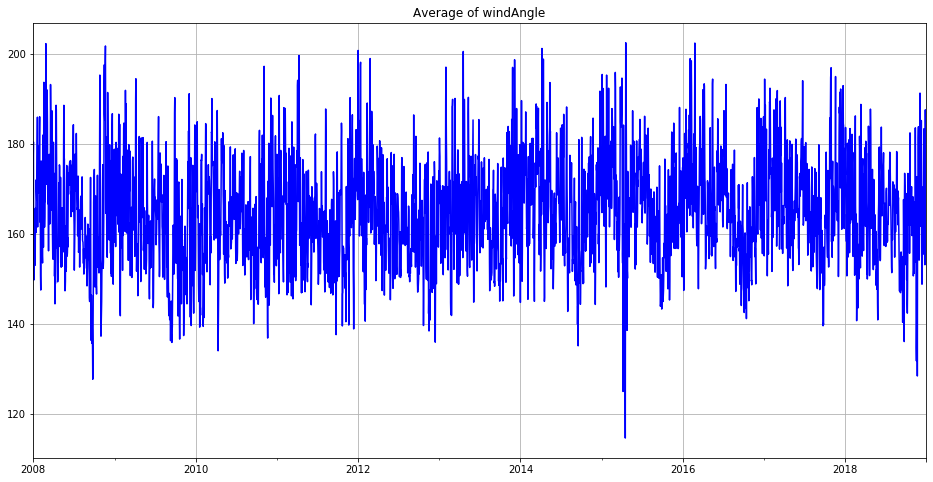

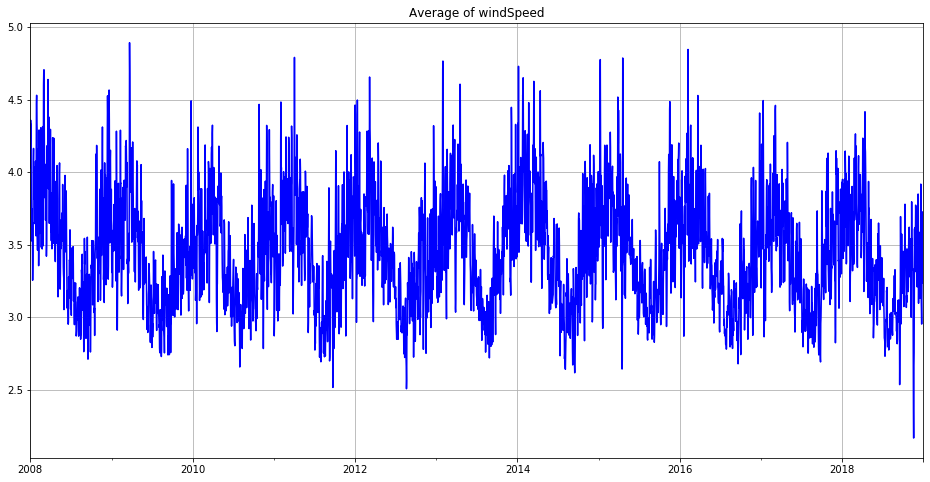

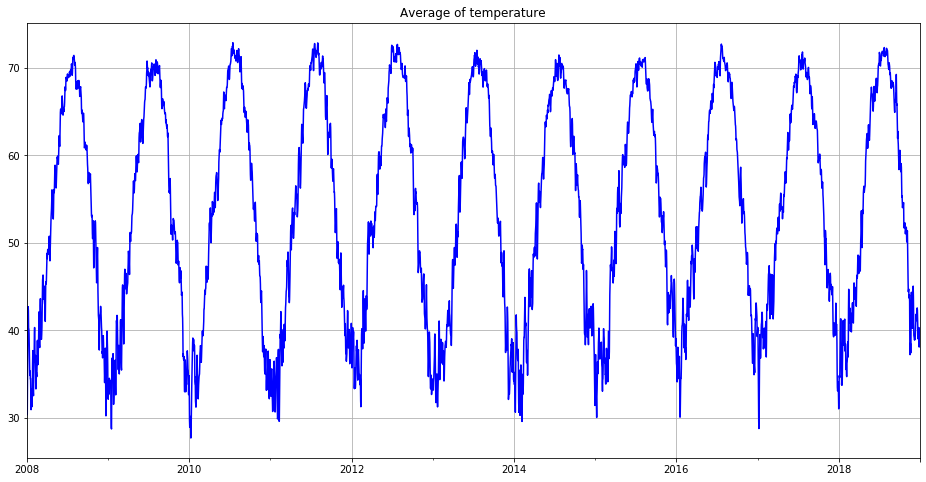

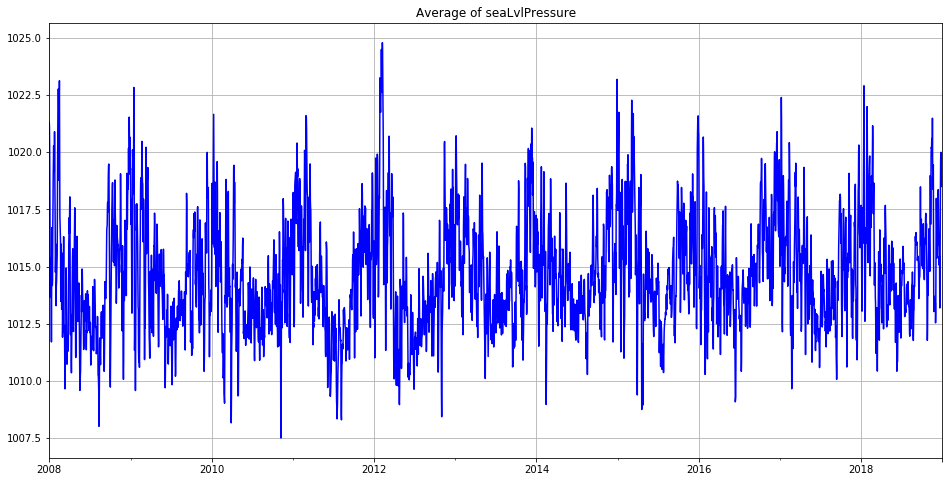

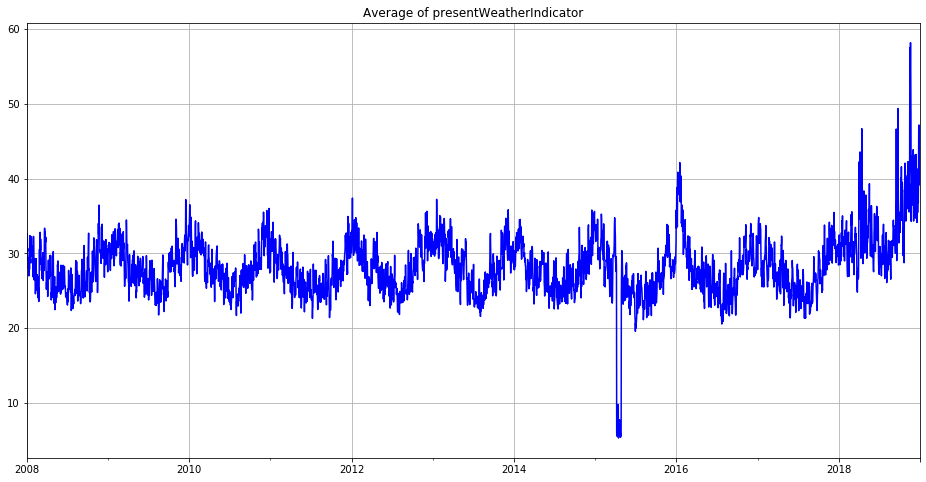

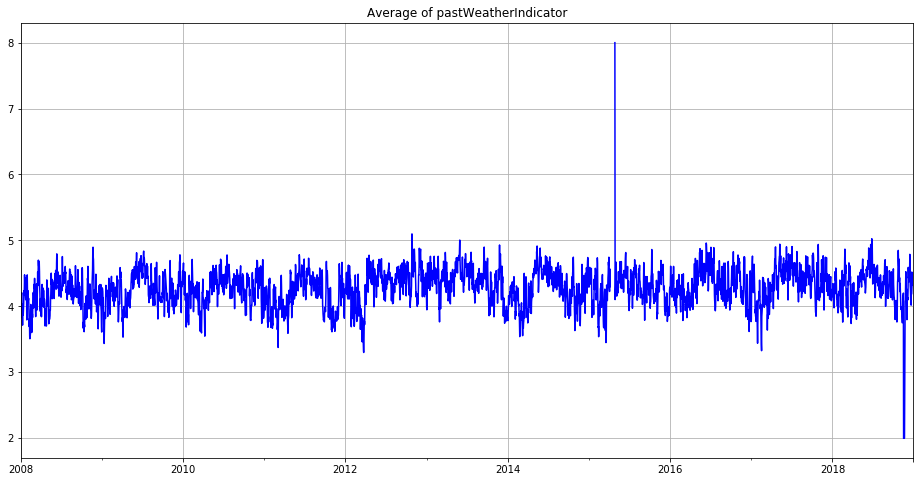

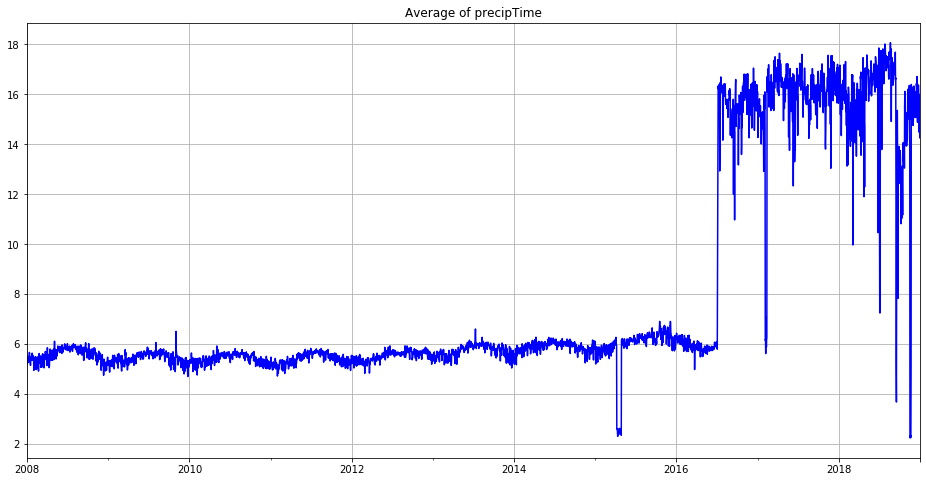

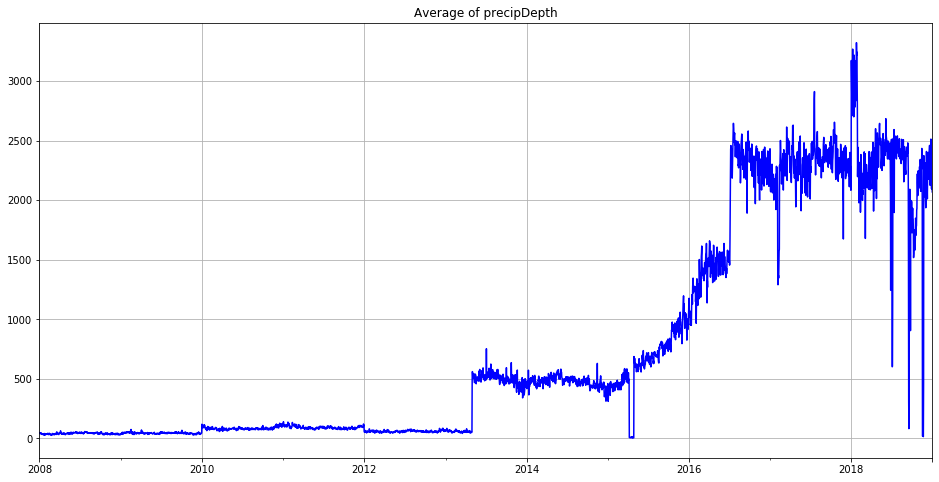

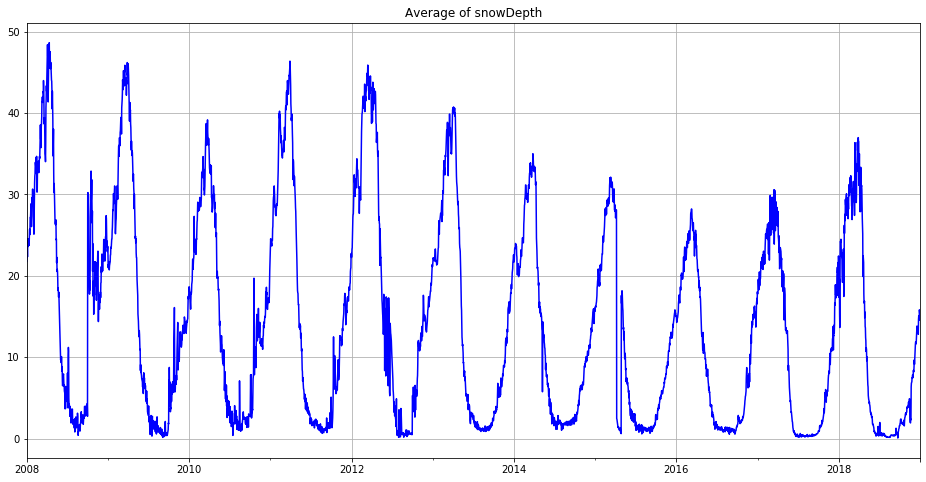

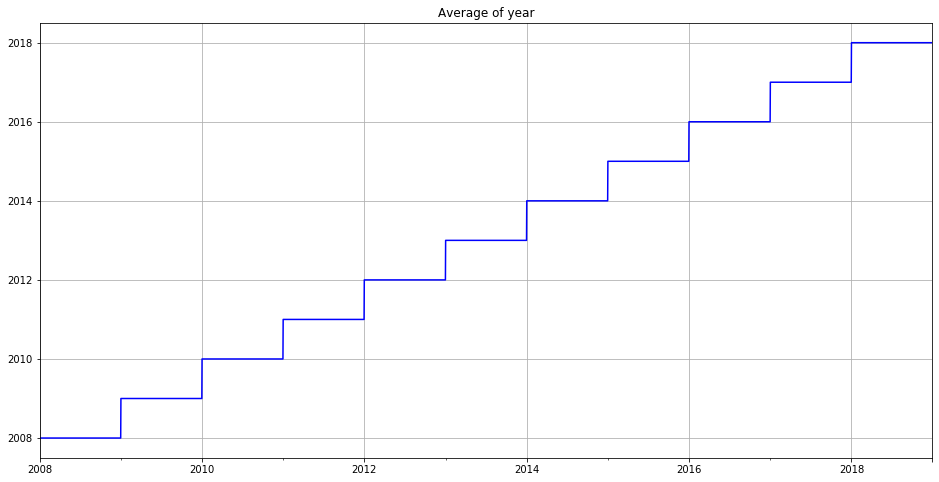

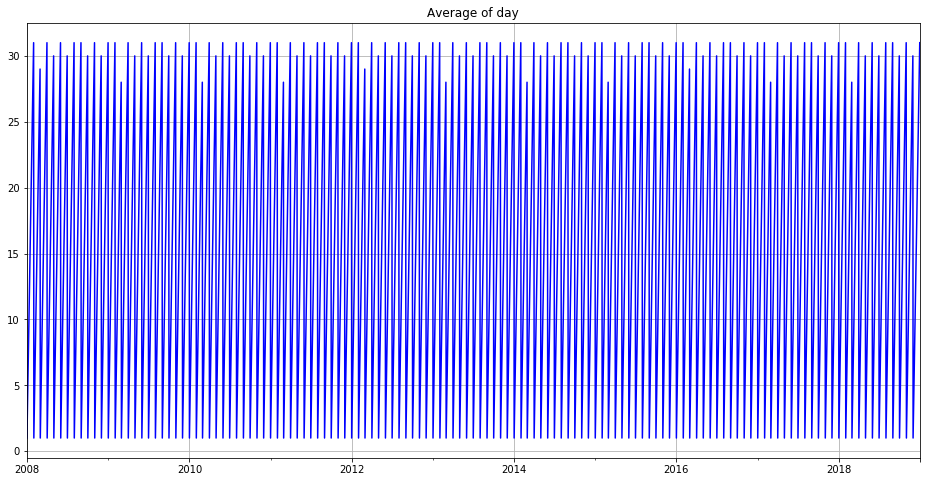

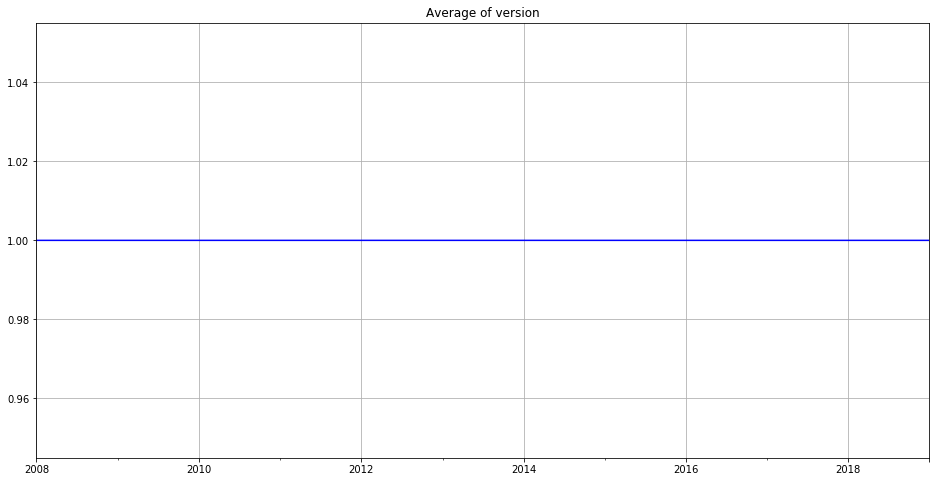

In [13]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2018, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [14]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-dask-demo,dask-dask-demo_1580592415_63cfafe7,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Transform data

In [15]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

## Explore

In [17]:
df = df.persist()

In [20]:
%time places = df.groupby(df.index)['longitude', 'latitude', 'year'].mean().compute()

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 2.22 s


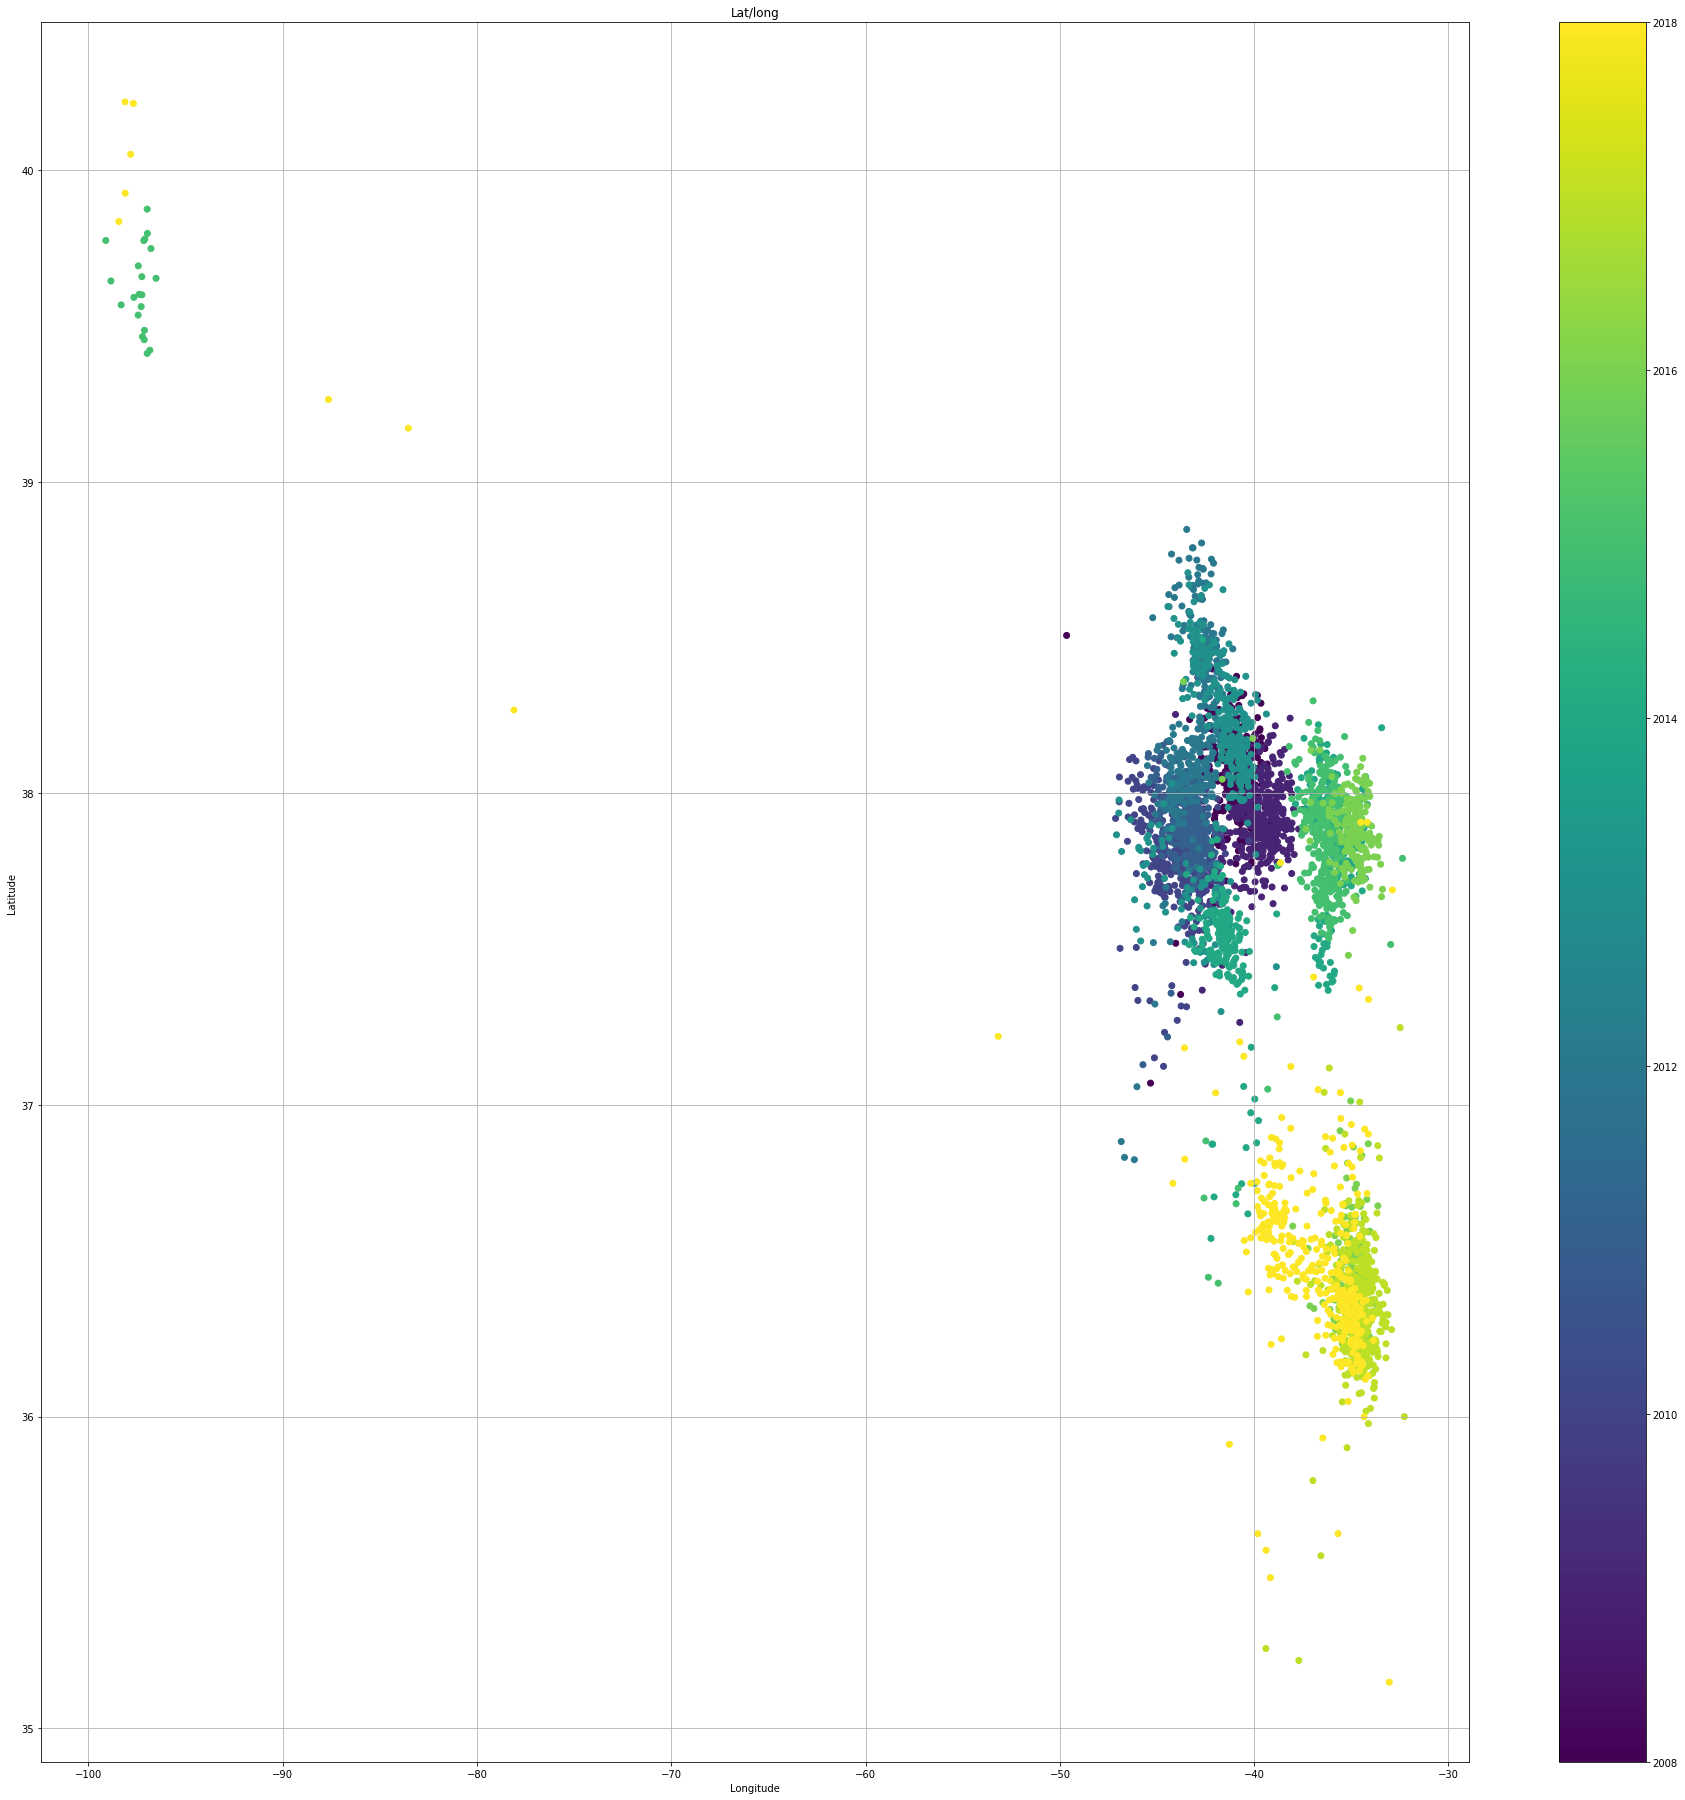

In [21]:
plt.figure(figsize=(32, 32))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

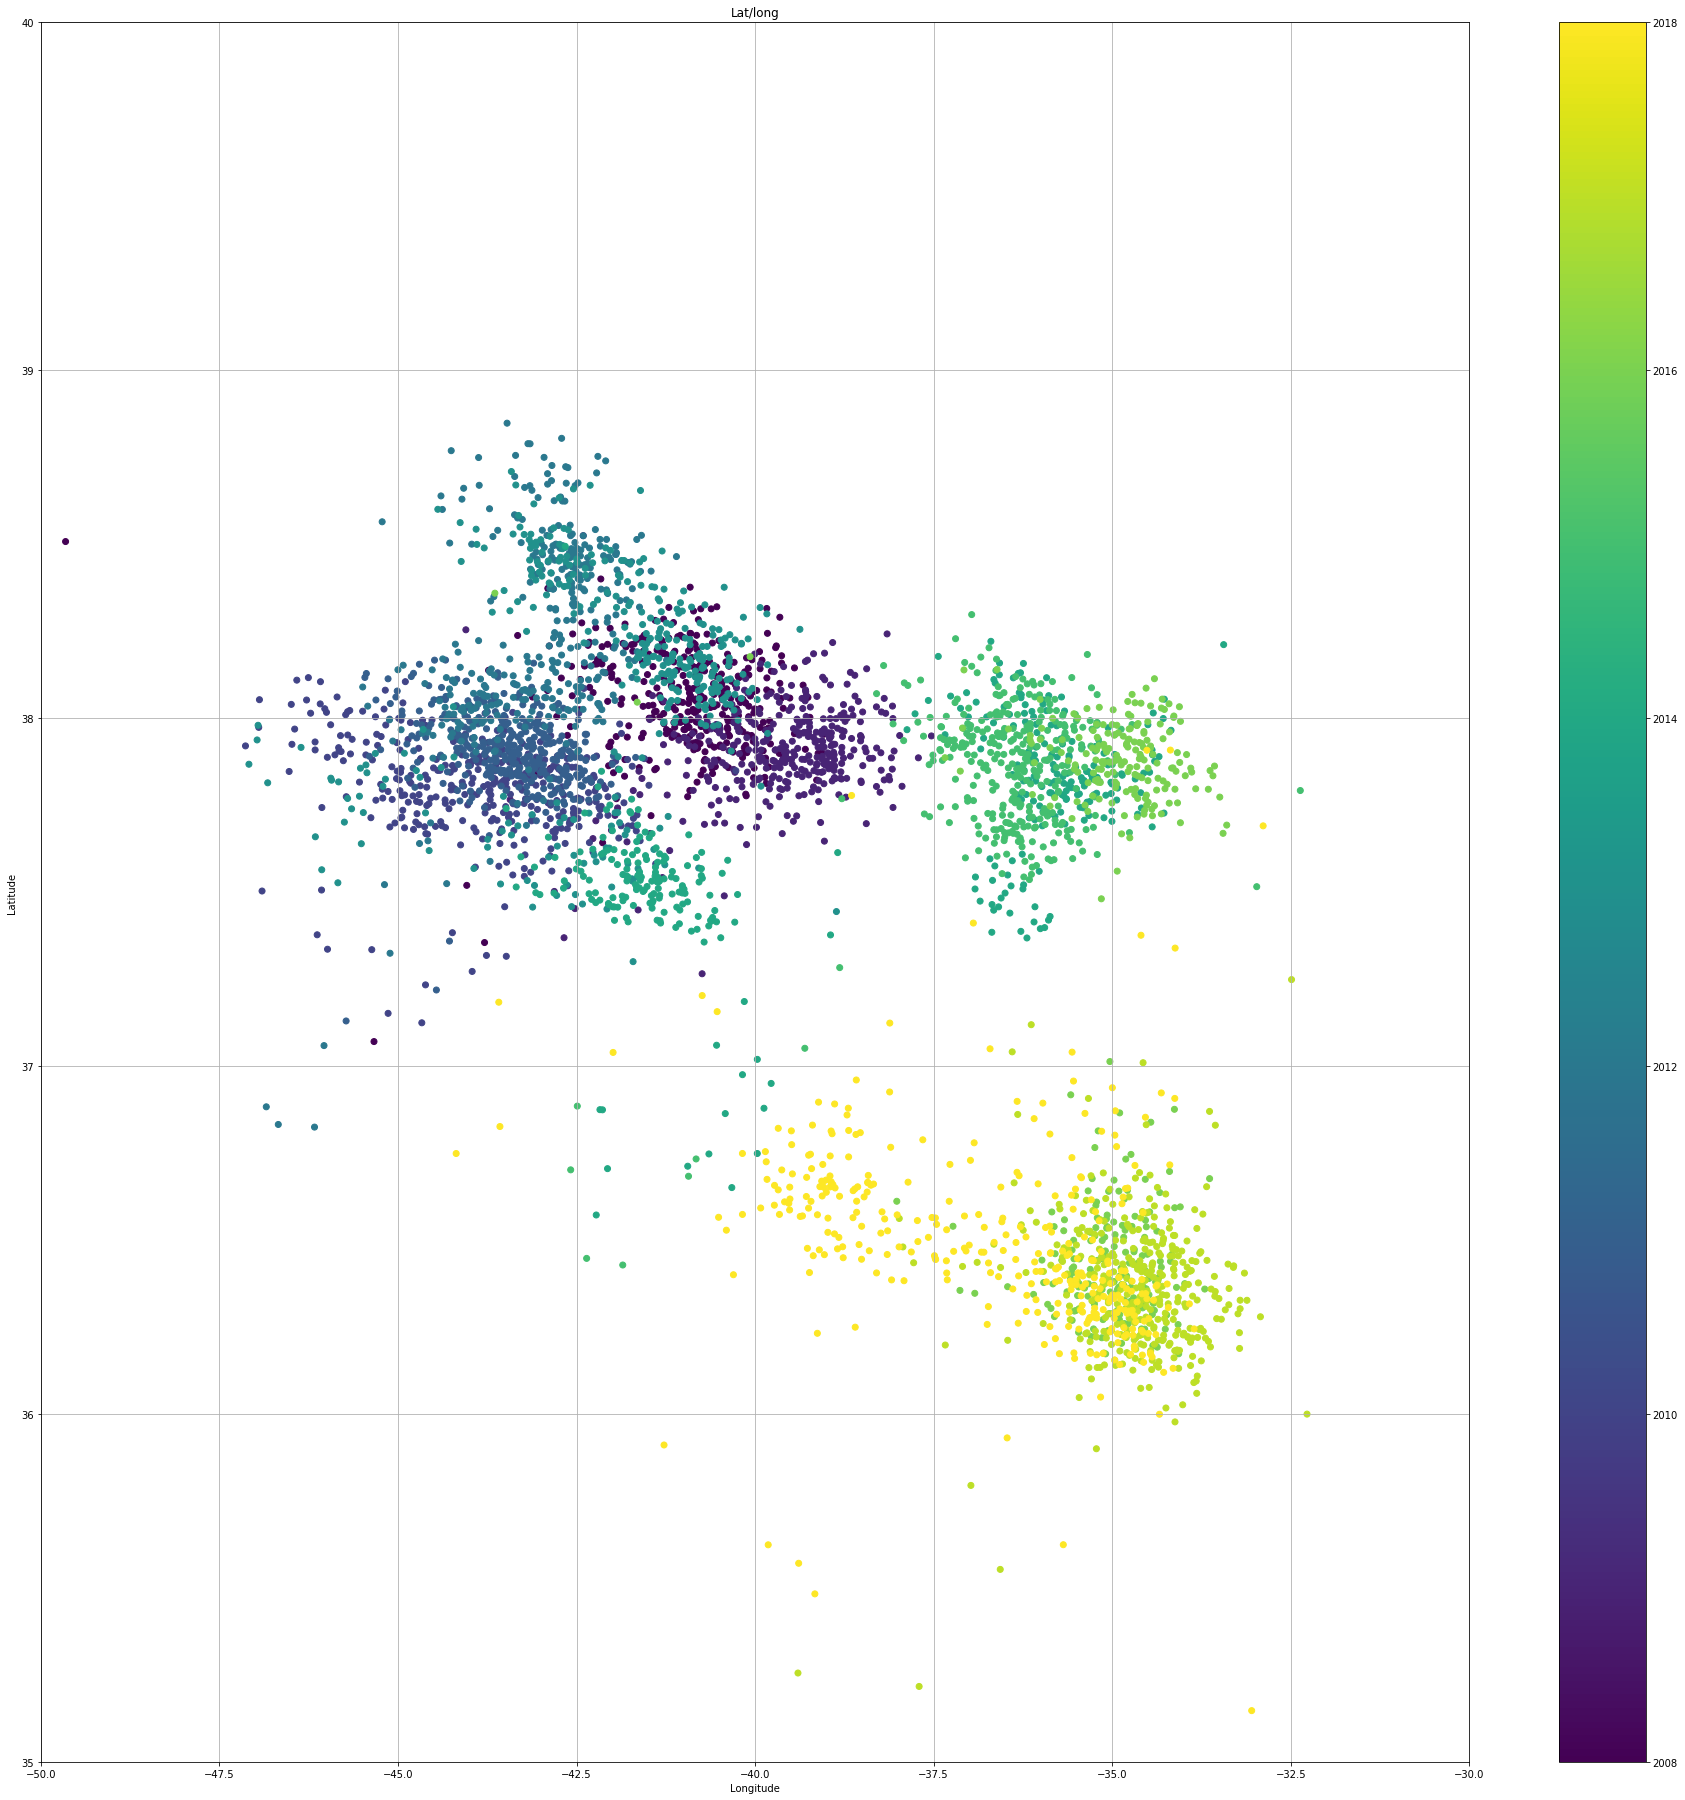

In [22]:
plt.figure(figsize=(32, 32))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30])
plt.ylim([35, 40])
plt.grid()
plt.colorbar()

In [24]:
%time counts = df.groupby(df.index)['year'].count().compute()

CPU times: user 229 ms, sys: 4.21 ms, total: 233 ms
Wall time: 934 ms


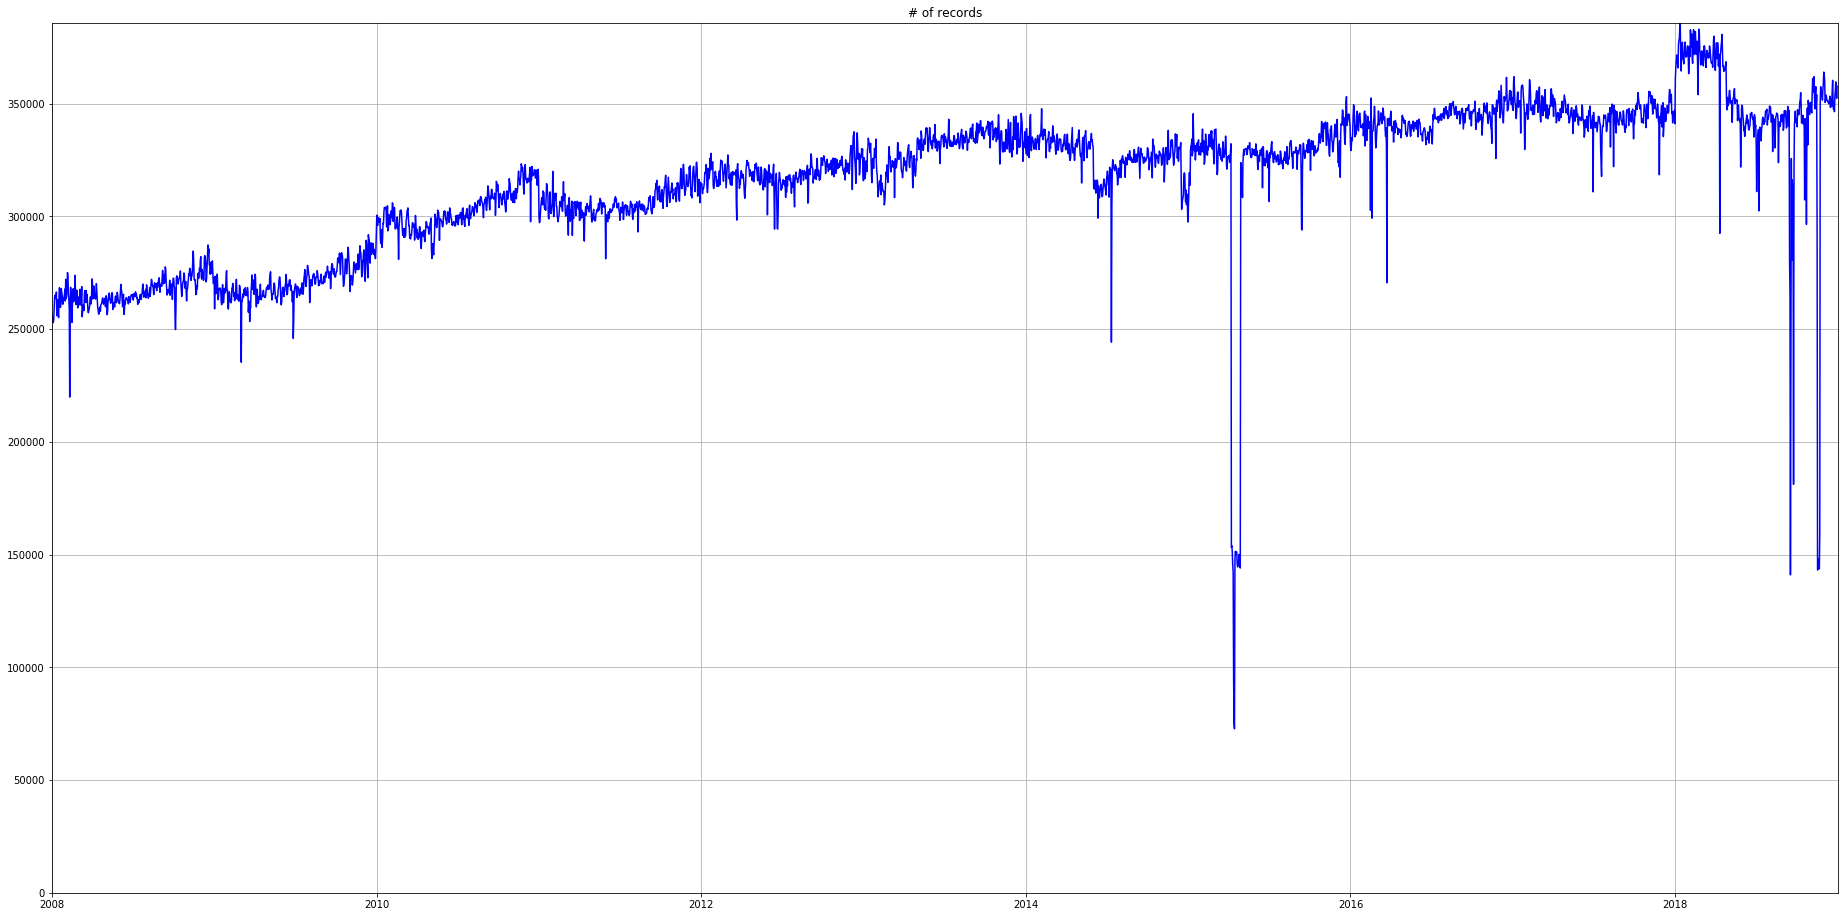

In [27]:
plt.figure(figsize=(32, 16))
plt.plot(counts, color='b')
plt.title('# of records')
plt.ylim([0, max(counts)])
plt.xlim([datetime(2008, 1, 1), datetime(2019, 1, 1)])
plt.grid()

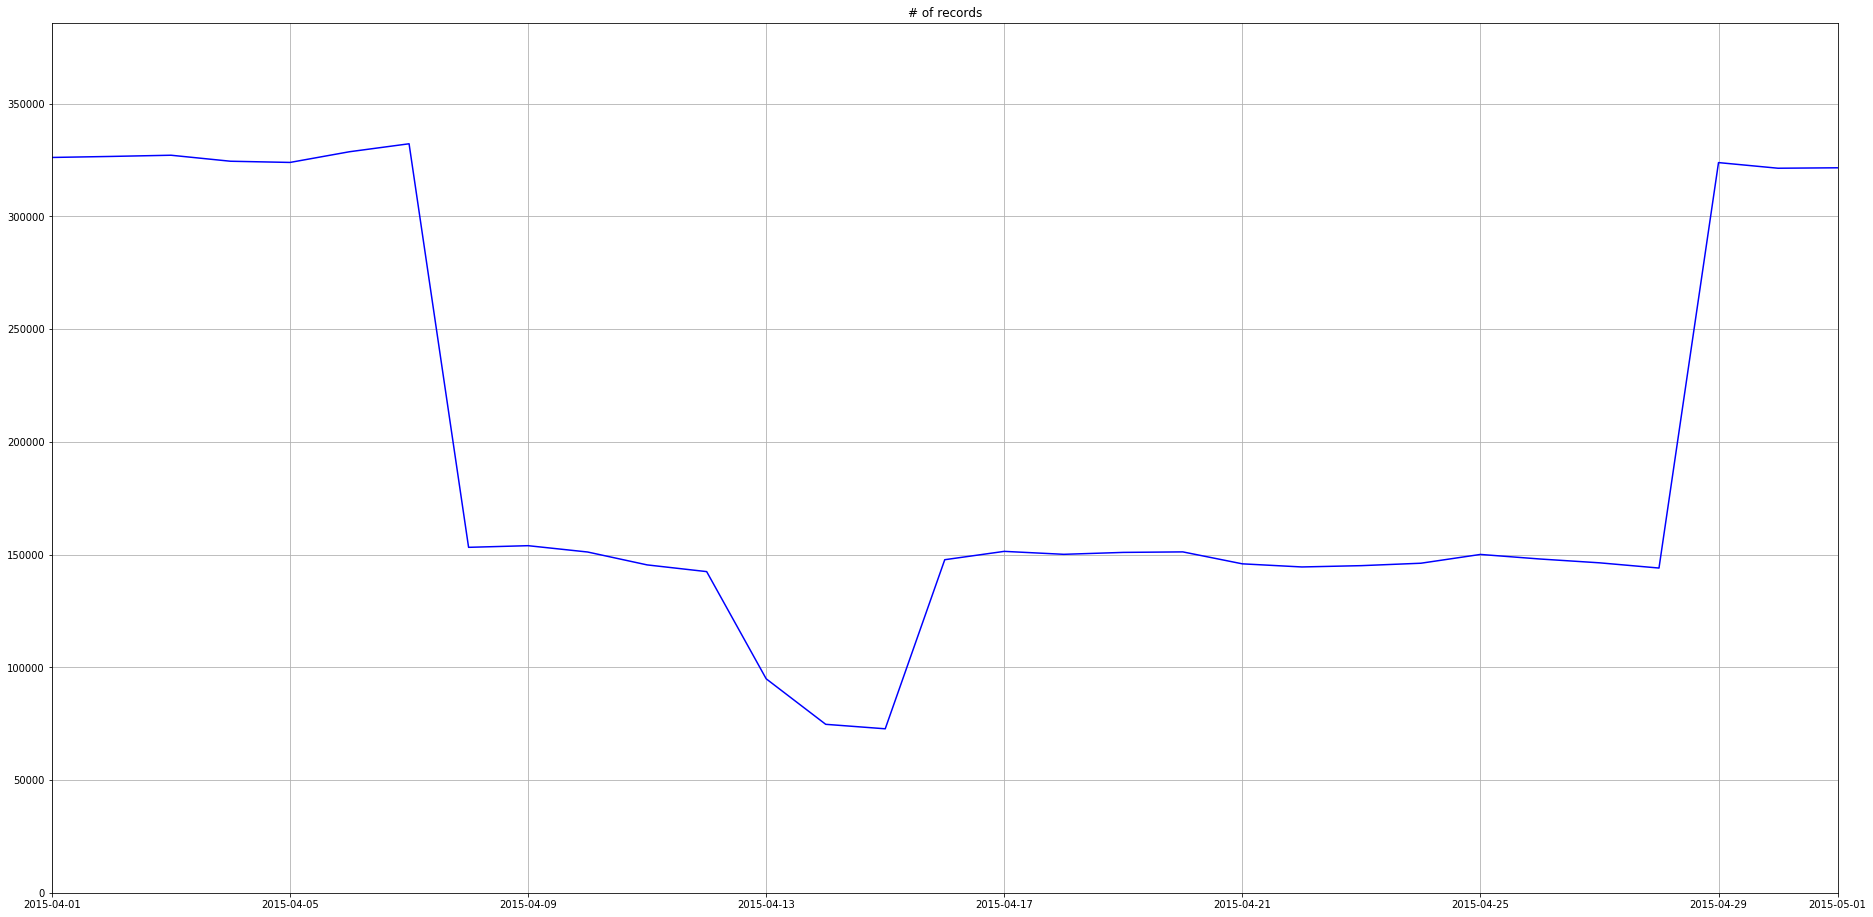

In [28]:
plt.figure(figsize=(32, 16))
plt.plot(counts, color='b')
plt.title('# of records')
plt.ylim([0, max(counts)])
plt.xlim([datetime(2015, 4, 1), datetime(2015, 5, 1)])
plt.grid()

In [29]:
stations = df.stationName.unique().compute()

In [30]:
stations

0        CEDAR CITY REGIONAL ARPT
1                          JAFFNA
2                         IQALUIT
3                        OTTOSDAL
4                           LINXI
                   ...           
16457                   TAROUDANT
16458                      TIZNIT
16459                      SETTAT
16460                  MOHAMMEDIA
16461                   EL JADIDA
Name: stationName, Length: 16462, dtype: object

In [31]:
df.temperature.min().compute()

-197.464

In [32]:
df.temperature.max().compute()

289.50800000000004

In [33]:
df.elevation.max().compute()

9999.0

In [34]:
df.elevation.min().compute()

-388.0

In [39]:
temp = df[df['year']==2015]
df.datetime = dd.to_datetime(df.datetime)
df = df.persist()
temp['month'] = df['datetime'].dt.month
temp = temp[(temp.month > 2) & (temp.month < 6)]
places = temp.groupby(temp.datetime.dt.floor('d'))['longitude', 'latitude', 'month'].mean().compute()

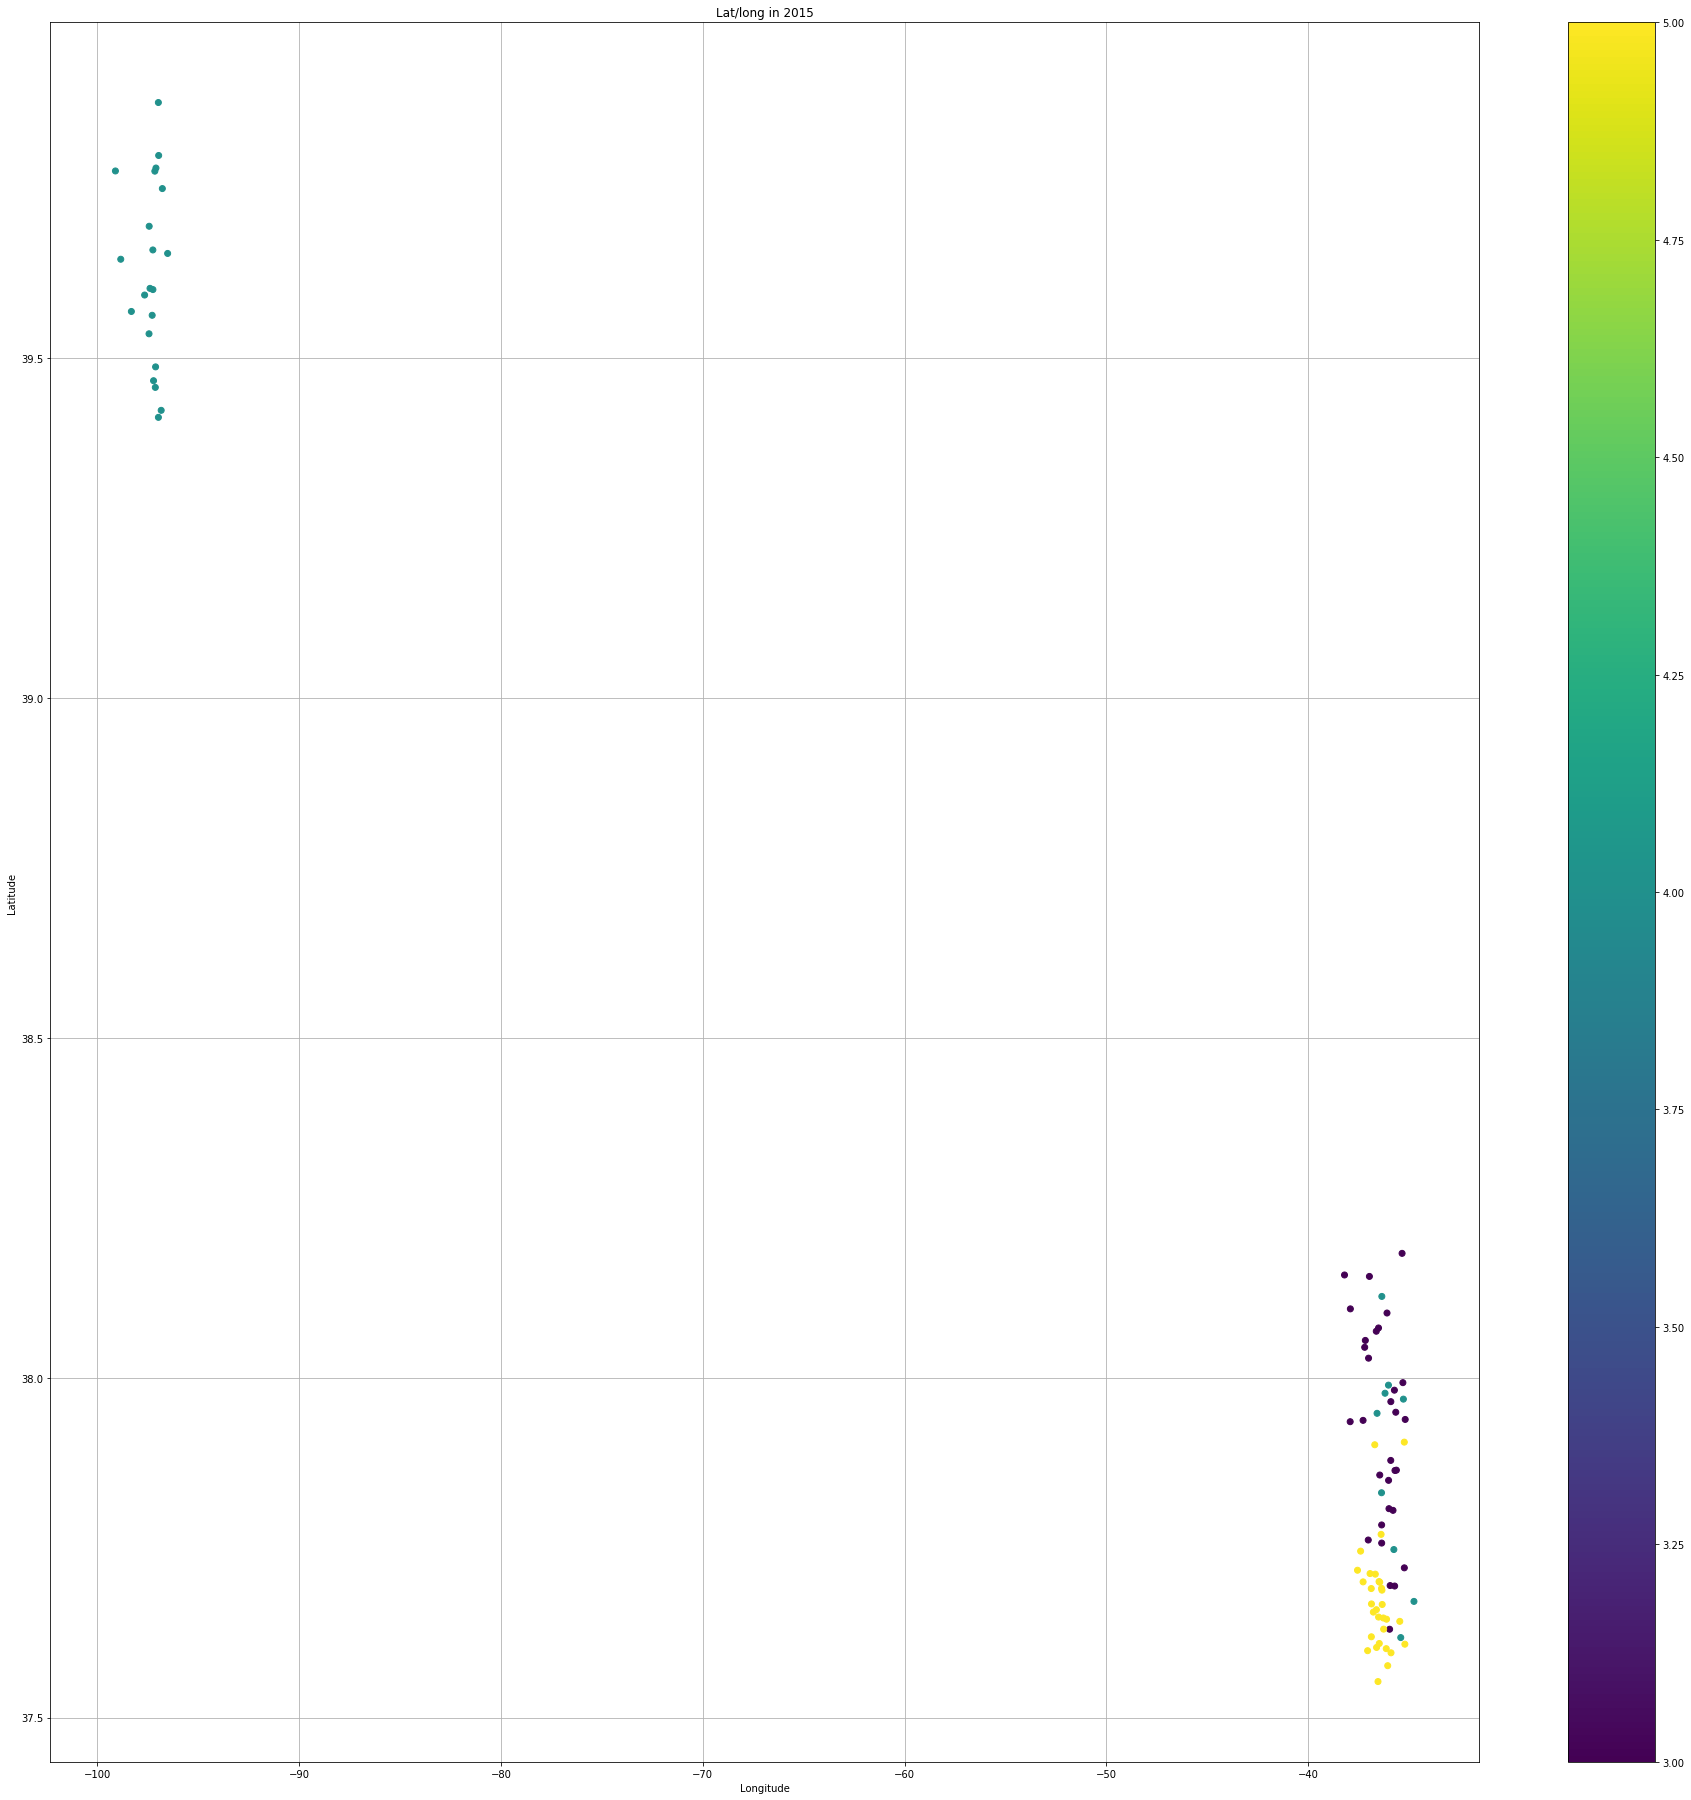

In [40]:
plt.figure(figsize=(32, 32))
plt.scatter(places.longitude, places.latitude, c=places['month'])
plt.title('Lat/long in 2015')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()